The steps we take for our analysis are basically

1. Classify sentences into topics e.g. service, fees, registration
2. Classify sentences within each topic as positive or negative
3. Count positive/negative within each topic
4. Perform linear/multi-linear regression between pos/neg in each topic, and
the rating associated the text that sentence belongs to.

In [75]:
import pandas as pd
import json

# Create new csv with labels 
csv_files = ["binance.csv", "coinbase.csv", "etoro.csv", "ftx.csv", "kraken.csv"]
li = []
for filename in csv_files:
    df = pd.read_csv(filename)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
data = frame.loc[:, ["content", "score", "reviewId"]]
#! Have to use str.len() becahse len(data["Content"] just gives you no. rows in data frame)
new_data = data.loc[(data["content"].str.len() > 50)] 
new_data.shape



(11297, 3)

In [76]:
# Break each review into sentences
reviews = new_data.loc[:, ["content"]]
sentenced_reviews = {"content": [], "rating": [], "reviewId": []}
new_data["sentences"] = new_data["content"].str.split(".");
new_data.head(10)

for index, content in new_data.iterrows():    
    for sentence in content["sentences"]:
        sentenced_reviews["content"].append(sentence)
        sentenced_reviews["rating"].append(content["score"])
        sentenced_reviews["reviewId"].append(content["reviewId"])

reviews = pd.DataFrame(sentenced_reviews)
reviews = reviews.loc[(reviews["content"].str.len() > 20)] # Only get sentences longer than about 5 words

/tmp/ipykernel_9812/811496203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["sentences"] = new_data["content"].str.split(".");


In [77]:
# Store the dataframe into csv and then we label about 100 sentences for training purposes
reviews["label"] = "NA"
reviews["isen"] = False;
reviews.head(100)

# Remove all non-english reviews
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language

def create_lang_detector(nlp, name):
    return LanguageDetector()

Language.factory("language_detector", func=create_lang_detector)
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("language_detector", name="language_detector", last=True)


def is_english(row):
    row["isen"] = (nlp(row["content"])._.language["language"] == "en")
    return row #! Must return the row for it to add to new dataframe

english_reviews = reviews.apply(is_english, axis="columns")
english_reviews = english_reviews.loc[(english_reviews["isen"] == True)]
english_reviews.head(100)

,content,rating,reviewId,label,isen
0,"Very good application, easy to understand for ...",5,a1e76af3-a141-49b3-962e-50a43e6c56c0,NA,True
1,For now I've been having a decent time in this...,3,8d18f2f9-0c5f-476a-be30-768e248d131a,NA,True
3,im from indonesia this app is really legit cr...,5,548d3f53-4610-4d13-866d-83cd7e0c04d8,NA,True
5,i think better then crypto exchange in indone...,5,548d3f53-4610-4d13-866d-83cd7e0c04d8,NA,True
7,depo and withdrawal so easy,5,548d3f53-4610-4d13-866d-83cd7e0c04d8,NA,True
...,...,...,...,...,...
138,when I didn't know crypto I only had a little ...,5,271a49bc-de8c-490d-9246-372a8fa90cd9,NA,True
139,"I would give you 0 star, I tried to create new...",1,b3c134eb-a09c-4429-9384-49e00de49696,NA,True
143,"Easy to use and Most successful cex for now, W...",5,ad63d746-24bb-4c30-a708-aebf1a89d8b9,NA,True
144,I chose Binance because it is one of the best ...,5,31f016ea-4e0e-4804-a967-694bef7163c5,NA,True


In [78]:
# Create sample dataset to label

# Define convention in terms of topics used
# NA - no topic assigned -> used for prediction 
# C - Customer service
# F - Fees
# R - Registration/Verification Issues
# D - Deposit/Withdrawals
# A - App itself e.g. user interface, ease of use, other features.
# T - Trust and company reputation
# O - Other issues
#! Grab review ID
# Sample 20 from each rating category and perform random topic labelling
long_reviews = english_reviews.loc[(reviews["content"].str.len() > 40)]
long_reviews["rating"].value_counts()
long_reviews.head(100)



,content,rating,reviewId,label,isen
0,"Very good application, easy to understand for ...",5,a1e76af3-a141-49b3-962e-50a43e6c56c0,NA,True
1,For now I've been having a decent time in this...,3,8d18f2f9-0c5f-476a-be30-768e248d131a,NA,True
3,im from indonesia this app is really legit cr...,5,548d3f53-4610-4d13-866d-83cd7e0c04d8,NA,True
5,i think better then crypto exchange in indone...,5,548d3f53-4610-4d13-866d-83cd7e0c04d8,NA,True
8,i hope binance will grow more big then now,5,548d3f53-4610-4d13-866d-83cd7e0c04d8,NA,True
...,...,...,...,...,...
187,Now I only use Binance for my crypto invesmen...,5,6151c97a-8a12-4c50-bb61-9b6efcb7c931,NA,True
195,Three star cuz of the delay and the high amoun...,3,f12e915e-0e0e-412d-b1a1-9c9f366c5e99,NA,True
196,Personally I don't like to compare but I thin...,3,f12e915e-0e0e-412d-b1a1-9c9f366c5e99,NA,True
198,Love to use binance as my main crypto wallet,5,8717246c-a663-4eeb-b210-1415f515a427,NA,True


In [66]:
# #! DO NOT RUN THIS - Accidentally overwrote labels of training dataset.
# training_set = []
# for rating, count in long_reviews["rating"].value_counts().items():
#     training_set.append(long_reviews.loc[long_reviews.rating == rating].sample(10))
# training_set = pd.concat(training_set, axis=0, ignore_index=True)
# training_set.head(100)
# training_set.to_csv("test.csv")


In [79]:
# Create new long_reviews with fixed indexes so we can transform it
new_long = long_reviews.copy()
new_long = new_long.reset_index()
new_long = new_long.drop(columns="index")
new_long.tail(100)


,content,rating,reviewId,label,isen
18778,I added 2 cards and tried several time but it...,1,5048aa6e-76d6-4554-8d56-549a4fe940af,NA,True
18779,"I just downloaded it and 1, there is no coin s...",3,59d908e8-3908-4e8f-9a0a-0095da7219a1,NA,True
18780,I have to scroll all the way down to find the...,3,59d908e8-3908-4e8f-9a0a-0095da7219a1,NA,True
18781,"Will not let me sign into account, registratio...",1,4170d3aa-ed05-4189-bf66-7df07f9a9b64,NA,True
18782,Withdrawal and so many fees chart also not upd...,1,2b8cd57c-e67b-4b28-b625-ce40cfe02e34,NA,True
...,...,...,...,...,...
18873,"Finally, a satisfying user friendly, clean & s...",5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True
18874,I can fund my account both wire & debit/credi...,5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True
18875,"Login is as usual, so far no problem using my...",5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True
18876,I believe this was intended for your average ...,5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True


In [80]:
training_set = pd.read_csv("training.csv")

In [81]:
training_set["label"].isnull().any()

False

In [82]:
# Convert each sentence into Bow before fitting model
# Text cleaning function we want ot apply to each document
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer



# TODO: Lower case all the words
def text_cleaning(a):
    remove_punctuation = [char for char in a if char not in string.punctuation]
    remove_punctuation = "".join(remove_punctuation)
    #! Probably might want to reduce words to only stems to remove duplicates
    return [word.lower() for word in remove_punctuation.split() if word.lower() not in stopwords.words("english")]


bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(new_long["content"])
bow_transformer.vocabulary_
training_bow = bow_transformer.transform(training_set["content"])
#! Need to createa new transformer for long_bow
# bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(long_reviews["content"])
long_bow = bow_transformer.transform(new_long["content"]);
print(training_set)

    Unnamed: 0                                            content  rating  \
0            0   I have been trying to set up my account again...       1   
1            1     Can't check my balance now, really bad service       1   
2            2  withdrawal is nightmare, if you are a profitab...       1   
3            3   5% for this transaction and it is so complicated       1   
4            4   their choice to go public means they have to ...       1   
..         ...                                                ...     ...   
95          95  I have just downloaded this app and have not u...       4   
96          96  easy to stake ethereum, doing part ethereum an...       4   
97          97  Exciting and motivating and informative Xx C t...       4   
98          98       Now it's a must for me to track my portfolio       4   
99          99    Original post 2017: Great app to start out with       4   

   label  isen  Unnamed: 5  Unnamed: 6  
0      C  True         NaN        

In [83]:
print(training_set["label"])
print(training_bow)

0     C
1     C
2     D
3     F
4     T
     ..
95    O
96    O
97    O
98    O
99    O
Name: label, Length: 100, dtype: object
  (0, 650)	1
  (0, 1669)	1
  (0, 8099)	1
  (0, 8175)	1
  (0, 9037)	1
  (0, 10442)	1
  (1, 1391)	1
  (1, 1402)	1
  (1, 1995)	1
  (1, 2160)	1
  (1, 8160)	1
  (1, 9028)	1
  (2, 6913)	1
  (2, 7880)	1
  (2, 10308)	1
  (2, 11246)	1
  (3, 407)	1
  (3, 2465)	1
  (3, 10339)	1
  (4, 1089)	1
  (4, 2183)	1
  (4, 2602)	1
  (4, 4726)	1
  (4, 5624)	1
  (4, 6321)	1
  :	:
  (97, 5435)	1
  (97, 5743)	1
  (97, 5788)	1
  (97, 6195)	1
  (97, 6720)	1
  (97, 7098)	2
  (97, 8048)	1
  (97, 8561)	1
  (97, 9525)	1
  (97, 9558)	1
  (97, 9839)	1
  (97, 9992)	1
  (97, 10928)	1
  (97, 11071)	1
  (97, 11132)	1
  (97, 11385)	3
  (98, 6761)	1
  (98, 7696)	1
  (98, 10288)	1
  (99, 201)	1
  (99, 1066)	1
  (99, 4809)	1
  (99, 7206)	1
  (99, 7720)	1
  (99, 9558)	1


In [84]:
#! Do not use NA as a label -> pandas interprets it as null
training_set["label"].isnull().any()

#!!! Remove NaN!
# training_set = training_set.loc[training_set["label"].isnull() != True]

False

In [85]:
training_set["label"]

0     C
1     C
2     D
3     F
4     T
     ..
95    O
96    O
97    O
98    O
99    O
Name: label, Length: 100, dtype: object

In [86]:
# Whilst we have successfully classified alot of the sentences/texts, we realise
# That the classification is biased towards the sample i.e. most reviews concern A
# in sample and so we get more As
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(training_bow, training_set["label"]) 

#! To make predictions - features/vocab of training set must == vocab of prediction set
all_predictions = model.predict(long_bow)
pred_df = pd.Series(name="prediction", data=all_predictions)
pred_df.value_counts()
pred_df.tail(100)

new_long = pd.concat([new_long, pred_df], axis=1, join="outer")
new_long.tail(90)

#Reset indexes of long reviews after making copy
# long_reviews["predictions"] = pred_df
# long_reviews.tail(90)
# long_reviews.to_csv("result.csv")

,content,rating,reviewId,label,isen,prediction
18788,Security feels reassuring just needs a similar...,4,7df4e0d3-9389-4182-9221-93ae84fed943,NA,True,A
18789,Superior customer service which is crucial if...,4,7df4e0d3-9389-4182-9221-93ae84fed943,NA,True,A
18790,Very important if say your funds wont withdra...,4,7df4e0d3-9389-4182-9221-93ae84fed943,NA,True,A
18791,The most basic interface possible I suppose,4,2c015d35-3ef6-4e7f-9a66-ea790b212712,NA,True,A
18792,"You won't use this to get the razor's edge, b...",4,2c015d35-3ef6-4e7f-9a66-ea790b212712,NA,True,A
...,...,...,...,...,...,...
18873,"Finally, a satisfying user friendly, clean & s...",5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True,A
18874,I can fund my account both wire & debit/credi...,5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True,R
18875,"Login is as usual, so far no problem using my...",5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True,A
18876,I believe this was intended for your average ...,5,ec4bae64-7537-4654-a08b-28f5f3f2f925,NA,True,A


In [36]:
new_long.loc[new_long["prediction"]=="R"].head(100)

,content,rating,reviewId,label,isen,prediction
11,The verification process is taking longer as i...,5,33193f0c-dab3-4565-b917-13bf8fa8982b,NA,True,R
45,I can't seem to verify my account for over a ...,3,f5da85ba-a22a-4768-a7d8-5896f7f02184,NA,True,R
61,It's the best app but I can't receive verifica...,4,8ed56927-eb9e-4003-9cd5-df24075494c6,NA,True,R
127,Just showing the loading page or log in page ...,2,09639c25-ebc9-47d6-a436-cbe7ae470110,NA,True,R
138,I applied for advance verification process an...,1,c749bb5f-66f5-4994-9ce1-6911ddd6010f,NA,True,R
...,...,...,...,...,...,...
1947,"Try to Uninstall and re-install, still i can'...",3,91082998-c418-41b4-97f8-bb7a54ba205f,NA,True,R
1969,Also annoying that it needs 3-factor id to lo...,3,f7a93202-4c42-4589-b10c-e5b7ee6417f4,NA,True,R
1981,They will auto sign u out and make u sign in ...,1,e1b0d35d-5253-4760-89b4-5efab90ba5ea,NA,True,R
1982,when u go to re sign in thye send your OLD nu...,1,e1b0d35d-5253-4760-89b4-5efab90ba5ea,NA,True,R


In [37]:
new_long.prediction.value_counts()

A    15385
O     1917
R      884
C      295
D      241
F      145
T        6
Name: prediction, dtype: int64

### Part 2 - Perform sentiment analysis on each topic and correlate with ratings
For this we will be using a pre-trained model

In [52]:
from textblob import TextBlob

def add_sentiment_cols(row):
    sent_obj = TextBlob(row["content"])
    row["sent_pol"] = sent_obj.sentiment.polarity
    row["sent_sub"] = sent_obj.sentiment.subjectivity
    return row;

new_long = new_long.apply(add_sentiment_cols, axis="columns")


In [53]:
#! Consider if you should remove based on too high subjectivity.
# Subjectivity != reliability - e.g can be subjective but true.
##! Removed subjectivity filter to get more data for sampling
useful_sentiment = new_long # < 0.4
useful_sentiment = new_long.loc[new_long["sent_sub"] > 0.6] # < 0.4
useful_sentiment.shape

(4800, 8)

In [54]:
useful_sentiment["prediction"].value_counts()

A    4198
O     324
R     132
C      66
D      43
F      37
Name: prediction, dtype: int64

In [55]:
# Create new DF to store whether sentiment is positive
sentiment_df = useful_sentiment.copy()
sentiment_df.reset_index(inplace=True)
sentiment_df.drop(columns="index", inplace=True)
sentiment_df["is_positive"] = sentiment_df["sent_pol"] > 0
sentiment_df.head(100)

,content,rating,reviewId,label,isen,prediction,sent_pol,sent_sub,is_positive
0,"Very good application, easy to understand for ...",5,a1e76af3-a141-49b3-962e-50a43e6c56c0,NA,True,A,0.671667,0.806667,True
1,For now I've been having a decent time in this...,3,8d18f2f9-0c5f-476a-be30-768e248d131a,NA,True,A,0.522222,0.622222,True
2,"Am happy, very very happy by using this amazin...",5,9b76db60-591e-4080-83ac-231084066226,NA,True,O,0.662500,0.850000,True
3,Secure and simple are words to describe this a...,5,0c85d52c-453f-4f49-b0fa-82bab680670b,NA,True,A,0.325000,0.614286,True
4,"Very bad diagrams and charts, non intuitive",4,b253067e-d4a7-4fc4-8f8d-57e5817f4d71,NA,True,A,-0.910000,0.866667,False
...,...,...,...,...,...,...,...,...,...
95,Binance application is the best crypto exchang...,5,57ebde2d-3c57-4259-901f-2df19c39c5f8,NA,True,A,0.781667,0.650000,True
96,"I am greatly helped by using the app, the UI ...",5,57ebde2d-3c57-4259-901f-2df19c39c5f8,NA,True,A,0.600000,0.650000,True
97,Then this application is very safe for everyo...,5,8334e86e-ab59-4944-8c8e-959905240f62,NA,True,A,0.650000,0.650000,True
98,thank you binance I hope binance can maintain ...,5,7ac1f4a2-3c8c-4d3e-b414-d0beb4eeb359,NA,True,A,0.700000,0.900000,True


In [56]:
sentiment_df["is_positive"].value_counts()
sentiment_df["is_positive"].isnull().any()

False

In [57]:
# for each sentence - select items with same review id, select ones with same topic, and average sent pol.
reviews_df = {"reviewId":[], "topic":[], "sent_pol": [], "sent_sub": [], "rating": []}
for reviewId in sentiment_df["reviewId"].unique():
    for category in sentiment_df["prediction"].unique():
        reviewer_sent_same_topic = sentiment_df.loc[(sentiment_df["reviewId"] == reviewId) & (sentiment_df["prediction"] == category)]
        if not reviewer_sent_same_topic.empty:
            sent_pol = reviewer_sent_same_topic["sent_pol"].mean()
            sent_sub = reviewer_sent_same_topic["sent_sub"].mean()
            reviews_df["reviewId"].append(reviewId)
            reviews_df["topic"].append(category)
            reviews_df["sent_pol"].append(sent_pol)
            reviews_df["sent_sub"].append(sent_pol)
            reviews_df["rating"].append(reviewer_sent_same_topic["rating"].mean())

reviews_df = pd.DataFrame(reviews_df)

In [58]:
reviews_df.head(10)


,reviewId,topic,sent_pol,sent_sub,rating
0,a1e76af3-a141-49b3-962e-50a43e6c56c0,A,0.671667,0.671667,5.0
1,8d18f2f9-0c5f-476a-be30-768e248d131a,A,0.522222,0.522222,3.0
2,9b76db60-591e-4080-83ac-231084066226,O,0.662500,0.662500,5.0
3,0c85d52c-453f-4f49-b0fa-82bab680670b,A,0.325000,0.325000,5.0
4,b253067e-d4a7-4fc4-8f8d-57e5817f4d71,A,-0.910000,-0.910000,4.0
5,67ae82ac-d22e-4820-998e-9dbad3b0acba,A,0.800000,0.800000,3.0
6,d987ae58-29ff-479b-b8c6-0b408f4f7dee,A,0.700000,0.700000,5.0
7,59ecaf4d-28c1-4ddd-9dcf-c53d378c5734,A,0.000000,0.000000,1.0
8,93b14461-96bb-40a8-8dd4-44577aac10be,A,-0.075455,-0.075455,1.0
9,c40ecc09-5928-4a19-b791-06b0b0bc8f9a,A,0.800000,0.800000,1.0


Text(0, 0.5, 'Rating')

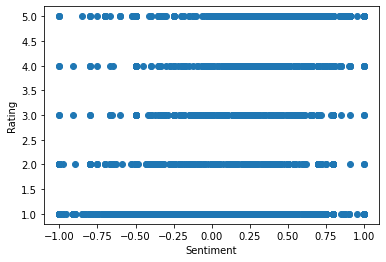

In [59]:
# See chart
import matplotlib.pyplot as plt
from importlib import reload
plt = reload(plt)
x = reviews_df[reviews_df["topic"] == "A"]["sent_pol"] #! When you don't use loc you get a series
y = reviews_df[reviews_df["topic"] == "A"]["rating"]

plt.scatter(x, y)
plt.xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
plt.ylabel("Rating")


In [60]:
x = reviews_df.loc[reviews_df["topic"] == "A"].loc[:, ["sent_pol"]]
x.head(100)

,sent_pol
0,0.671667
1,0.522222
3,0.325000
4,-0.910000
5,0.800000
...,...
101,0.670758
103,0.375000
104,0.333333
106,0.428889


In [61]:
# Create the model and display fit
from sklearn import linear_model
model = linear_model.LinearRegression()
x = reviews_df.loc[reviews_df["topic"] == "A"].loc[:, ["sent_pol"]]
model.fit(x, y)
model.score(x, y)

0.21598216414008897

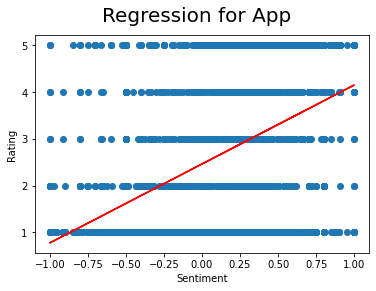

In [62]:
# Display the model
x = reviews_df[reviews_df["topic"] == "A"]["sent_pol"]
plt.scatter(x, y)
plt.suptitle("Regression for App", fontsize=20)
plt.xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
plt.ylabel("Rating")
plt.plot(x, model.coef_*x + model.intercept_, "r") 

In [63]:
topic_dict = {
    "A" : "App/UI/Features",
    "O" : "Other aspects",
    "F" : "Fees",
    "D" : "Deposit/Withdrawals/Transaction Handling",
    "R" : "Registration/Verification Process",
    "C" : "Customer Service",
    "T" : "Trust and Company Reputation"
}

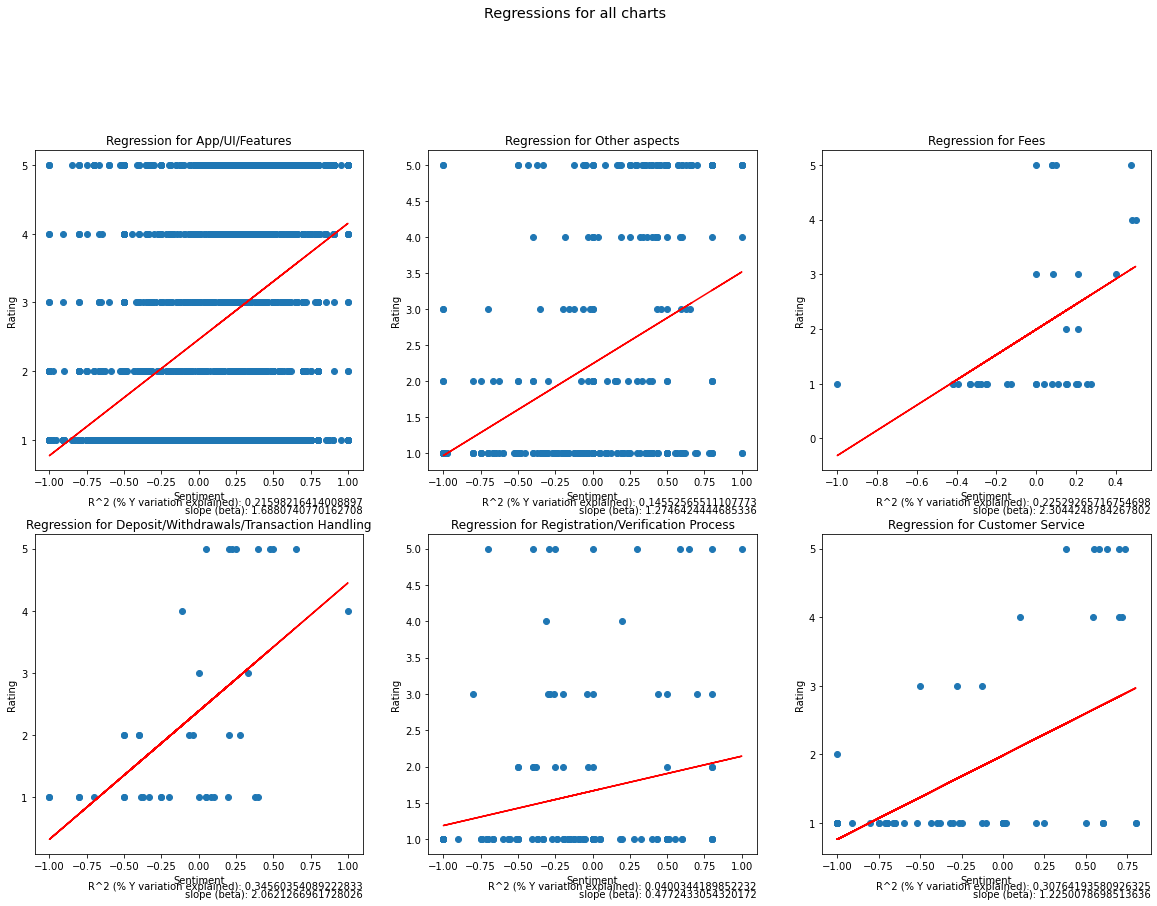

In [64]:
# Now we plot for all the topic
fig = plt.figure(figsize=(20,20))
st = fig.suptitle("Regressions for all charts", fontsize="x-large")

idx = 1
for key in reviews_df["topic"].unique():
    y = reviews_df[reviews_df["topic"] == key]["rating"]
    x = reviews_df.loc[reviews_df["topic"] == key].loc[:, ["sent_pol"]]
    model.fit(x, y)
    score = model.score(x, y)
    x = reviews_df[reviews_df["topic"] == key]["sent_pol"]
    curr_plot = fig.add_subplot(3, 3, idx)
    curr_plot.scatter(x, y)
    curr_plot.set_title(f"Regression for {topic_dict[key]}")
    curr_plot.set_xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
    curr_plot.set_ylabel("Rating")
    curr_plot.plot(x, model.coef_*x + model.intercept_, "r") 
    curr_plot.annotate(f"slope (beta): {model.coef_[0]}",
            xy = (1.0, -0.125),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
    curr_plot.annotate(f"R^2 (% Y variation explained): {score}",
            xy = (1.0, -0.1),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

    idx = idx + 1

fig.show()
    

In [65]:
reviews_df.to_csv("sent_crypto.csv")

### Analysis

1. Strongest overall fit/slope seems to do with deposits/withdrawals, followed by customer service and fees - This indicates that a good withdarwal experience has a significant impact on the overall rating of the customer
2. Weakest overall fit/slope seemes to relate to registration/verification process - this means that a poor verification/registration process is not a significant factor influencing the the reviews.



In [ ]:
# Count number of sentiment in each category
count_df = {"topic" : [], "pos_count" : [], "neg_count": []}
for key in sentiment_df["prediction"].unique():
    pos_df = sentiment_df.loc[(sentiment_df["is_positive"] == True) & (sentiment_df["prediction"] == key)] #! .loc returns boolean index error
    neg_df = sentiment_df.loc[(sentiment_df["is_positive"] == False) & (sentiment_df["prediction"] == key)] #! .loc returns boolean index error
    count_df["topic"].append(key)
    count_df["pos_count"].append(pos_df.shape[0])
    count_df["neg_count"].append(neg_df.shape[0])
count_df = pd.DataFrame(count_df)
count_df.head(100)
# df[(df["prediction" )]

,topic,pos_count,neg_count
0,A,2553,1645
1,O,148,176
2,F,20,17
3,D,20,23
4,R,39,93
5,C,20,46


In [88]:
# perform regressionbetween pos count/neg count and the rating? 
#! For got to stash rating information. -> y = rating X = each feature's sentiment score? so each sentence's labelled sentiment score (Do for each topic)

# Need to average sentiment for topic per person () e.g. Review X - topic 1 : setnence 1 = 0.5, sentence  2 = 0.3, overall sentiment for s = 0.4
# Not fair as that gives higher weighting to longer reviews - e.g. 999 good reviews 1 setennce, 1 bad review with 1000 sentences.
# Extra: 100 words - 20 words on app, 10 words on 
# Y = Rating, X = Sentiment for topic between -1 and 1 (6 columns of xs - A, O, T), each point (unit of analysis) = review (not single sentence)

# IF you can find something interesting then just stop -> and find supplementary analysis to support the findings.
# Compare this to other finance apps.

#TODO: Assess the quality of the text classificaiton model on the test set

# Convert test set to bag of words
# def text_cleaning(a):
#     remove_punctuation = [char for char in a if char not in string.punctuation]
#     remove_punctuation = "".join(remove_punctuation)
#     #! Probably might want to reduce words to only stems to remove duplicates
#     return [word.lower() for word in remove_punctuation.split() if word.lower() not in stopwords.words("english")]


# bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(new_long["content"])
# bow_transformer.vocabulary_
# training_bow = bow_transformer.transform(training_set["content"])
# #! Need to createa new transformer for long_bow
# # bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(long_reviews["content"])
# long_bow = bow_transformer.transform(new_long["content"]);
# print(training_set)

test_set = pd.read_csv("test.csv")
bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(long_reviews["content"])
test_bow = bow_transformer.transform(test_set["content"])
model = MultinomialNB().fit(training_bow, training_set["label"]) 

#! To make predictions - features/vocab of training set must == vocab of prediction set
all_predictions = model.predict(test_bow)
pred_df = pd.Series(name="prediction", data=all_predictions)
model.predict(test_bow)

# model.

array(['A', 'A', 'A', 'A', 'A', 'O', 'A', 'A', 'O', 'A', 'A', 'A', 'O',
       'A', 'A', 'A', 'A', 'O', 'A', 'A', 'R', 'A', 'A', 'O', 'A', 'A',
       'A', 'O', 'A', 'A', 'A', 'O', 'A', 'O', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'O', 'O'], dtype='<U1')

In [91]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_set["label"], all_predictions)
#! From confusion matrix it seems that text classifier is not that effective.

array([[24,  0,  0,  0,  4,  1,  0],
       [ 1,  0,  0,  0,  2,  0,  0],
       [ 8,  0,  0,  0,  1,  0,  0],
       [ 1,  0,  0,  0,  1,  0,  0],
       [ 2,  0,  0,  0,  1,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  1,  0,  0]])

In [71]:
print(test_bow)

  (0, 1441)	1
  (0, 3666)	1
  (0, 6166)	1
  (0, 7105)	1
  (0, 7689)	1
  (0, 10513)	1
  (0, 10931)	1
  (1, 977)	1
  (1, 1994)	1
  (1, 6159)	1
  (1, 8197)	1
  (1, 10708)	1
  (2, 3063)	1
  (2, 3397)	1
  (2, 5706)	1
  (2, 7144)	1
  (2, 8267)	1
  (2, 9605)	1
  (3, 3198)	1
  (3, 5756)	1
  (3, 6761)	1
  (3, 7076)	1
  (3, 7901)	1
  (3, 8636)	1
  (3, 8659)	1
  :	:
  (46, 613)	1
  (46, 947)	1
  (46, 4810)	1
  (46, 8112)	1
  (46, 10303)	1
  (47, 837)	1
  (47, 1066)	1
  (47, 3587)	1
  (47, 5212)	1
  (47, 5869)	1
  (47, 6894)	1
  (47, 10774)	1
  (47, 11226)	1
  (47, 11391)	1
  (48, 406)	1
  (48, 723)	1
  (48, 1915)	1
  (48, 2259)	1
  (49, 2720)	1
  (49, 2969)	1
  (49, 3587)	1
  (49, 4143)	1
  (49, 5677)	1
  (49, 5706)	1
  (49, 9802)	1
